# Spectrally Normalized Generative Adversarial Networks (SN-GAN)

https://arxiv.org/abs/1802.05957

In [ ]:
# Some setup
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for our testing purposes, please do not change!

'''
Function for visualizing images: Given a tensor of images, number of images, and
size per image, plots and prints the images in an uniform grid.
'''
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [ ]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
    z_dim: the dimension of the noise vector, a scalar
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white, so that's our default
    hidden_dim: the inner dimension, a scalar
    '''
    
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.gen = nn.Sequential(
            self.make_gen_block(z_dim, hidden_dim * 4),
            self.make_gen_block(hidden_dim * 4, hidden_dim * 2, kernel_size=4, stride=1),
            self.make_gen_block(hidden_dim * 2, hidden_dim),
            self.make_gen_block(hidden_dim, im_chan, kernel_size=4, final_layer=True),
        )

    def make_gen_block(self, input_channels, output_channels, kernel_size=3, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a generator block of the DCGAN, 
        corresponding to a transposed convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.ConvTranspose2d(input_channels, output_channels, kernel_size, stride),
                nn.Tanh(),
            )

    def unsqueeze_noise(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a copy of that noise with width and height = 1 and channels = z_dim.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        '''
        Function for completing a forward pass of the Generator: Given a noise vector, 
        returns a generated image.
        Parameters:
        noise: a noise tensor with dimensions (batch_size, z_dim)
        '''
        x = self.unsqueeze_noise(noise)
        return self.gen(x)

def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating a noise vector: Given the dimensions (n_samples, z_dim)
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
    n_samples: the number of samples in the batch, a scalar
    z_dim: the dimension of the noise vector, a scalar
    device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

In [ ]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
    im_chan: the number of channels of the output image, a scalar
            MNIST is black-and-white (1 channel), so that's our default.
    hidden_dim: the inner dimension, a scalar
    '''

    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            self.make_disc_block(im_chan, hidden_dim),
            self.make_disc_block(hidden_dim, hidden_dim * 2),
            self.make_disc_block(hidden_dim * 2, 1, final_layer=True),
        )

    def make_disc_block(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
        '''
        Function to return a sequence of operations corresponding to a discriminator block of the DCGAN, 
        corresponding to a convolution, a batchnorm (except for in the last layer), and an activation
        Parameters:
        input_channels: how many channels the input feature representation has
        output_channels: how many channels the output feature representation should have
        kernel_size: the size of each convolutional filter, equivalent to (kernel_size, kernel_size)
        stride: the stride of the convolution
        final_layer: whether we're on the final layer (affects activation and batchnorm)
        '''
        
        # Build the neural block
        if not final_layer:
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(0.2, inplace=True),
            )
        else: # Final Layer
            return nn.Sequential(
                nn.utils.spectral_norm(nn.Conv2d(input_channels, output_channels, kernel_size, stride)),
            )

    def forward(self, image):
        '''
        Function for completing a forward pass of the Discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
        image: a flattened image tensor with dimension (im_dim)
        '''
        disc_pred = self.disc(image)
        return disc_pred.view(len(disc_pred), -1)

In [ ]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
# A learning rate of 0.0002 works well on DCGAN
lr = 0.0002

# These parameters control the optimizer's momentum, which you can read more about here:
# https://distill.pub/2017/momentum/ but you don’t need to worry about it for this course
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

# We tranform our image values to be between -1 and 1 (the range of the tanh activation)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

# We initialize the weights to the normal distribution
# with mean 0 and standard deviation 0.02
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.6974213787317275, discriminator loss: 0.694515864014626


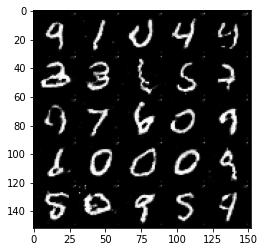

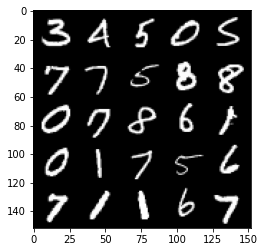

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.6954245457649225, discriminator loss: 0.6932731894254691


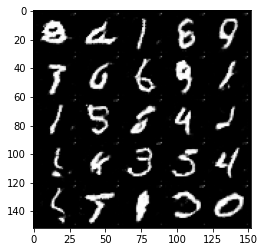

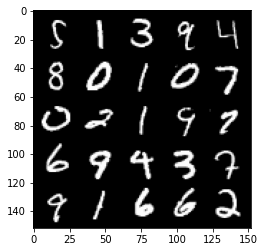

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.6958044483661652, discriminator loss: 0.6932826404571534


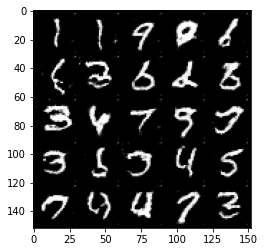

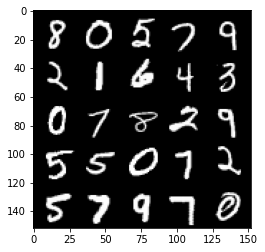

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6955134224891659, discriminator loss: 0.6931166703701024


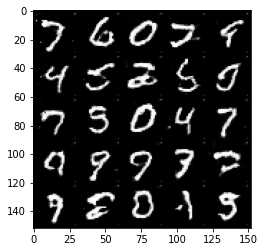

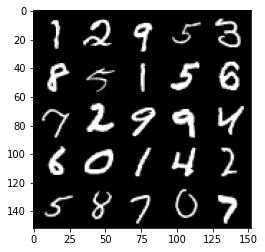

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.6950889430046078, discriminator loss: 0.6931857025623317


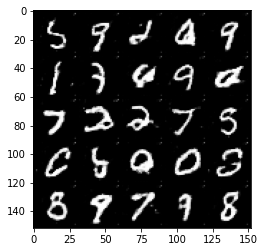

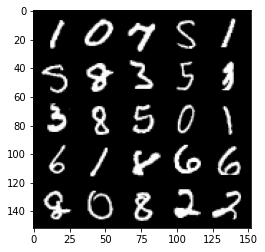

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.695133633852005, discriminator loss: 0.69340330684185


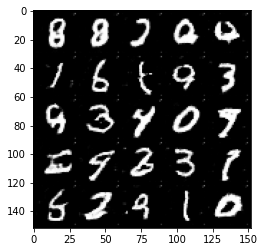

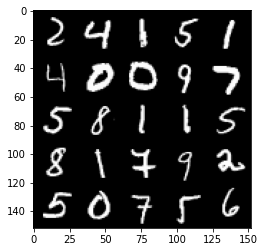

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.6957886500358587, discriminator loss: 0.6934609302282332


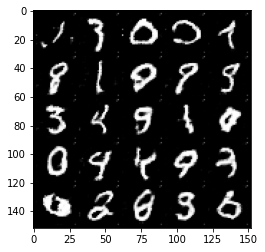

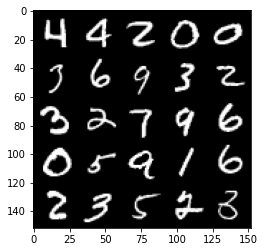

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.6946762415170673, discriminator loss: 0.693200428009034


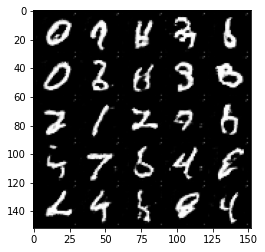

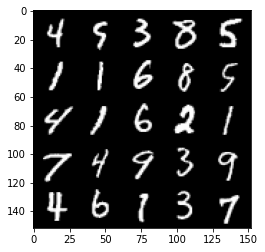

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.6943971964120869, discriminator loss: 0.6933914119005199


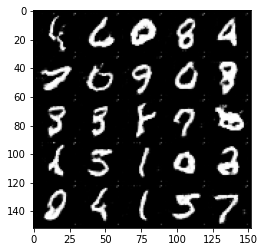

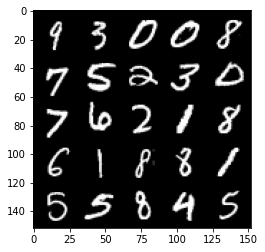

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.6948087314367304, discriminator loss: 0.693378748893738


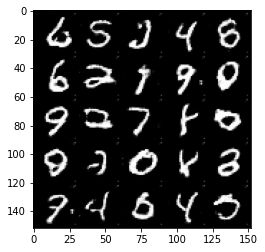

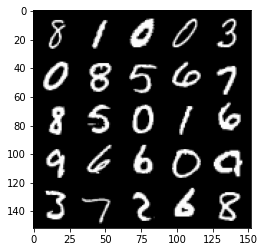

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.6949075613021843, discriminator loss: 0.6936038435697557


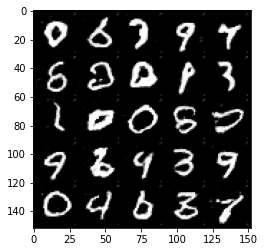

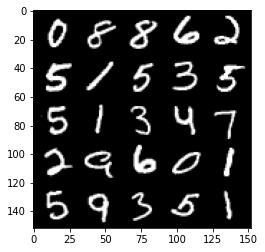

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6939722487926474, discriminator loss: 0.6934552124738694


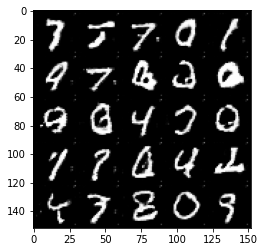

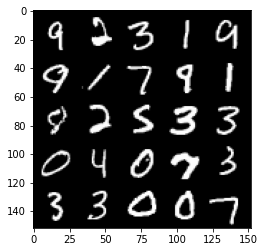

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.6954075589179991, discriminator loss: 0.6935142004489897


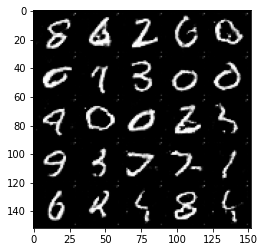

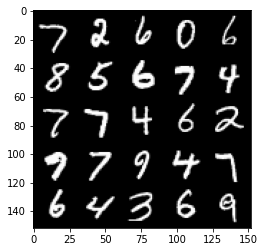

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.6938815398216245, discriminator loss: 0.6934661526679992


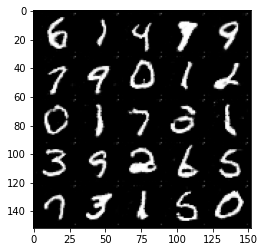

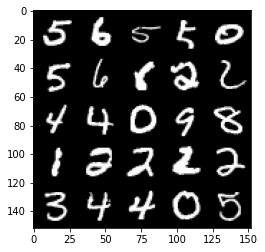

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.6941189824342716, discriminator loss: 0.6934387795925143


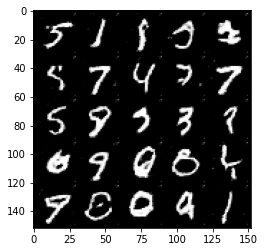

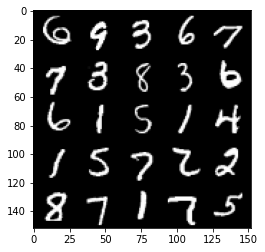

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.694436230182647, discriminator loss: 0.6934893804788594


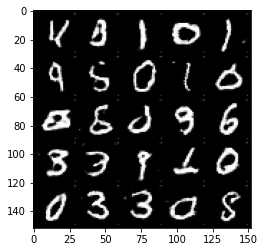

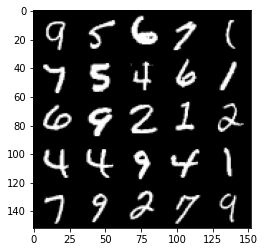

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.6945769585371023, discriminator loss: 0.693485751152038


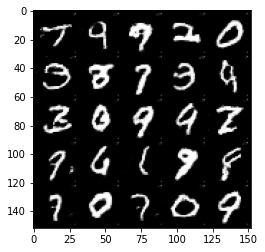

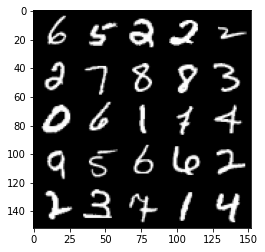

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.6943251225948335, discriminator loss: 0.6934114505052564


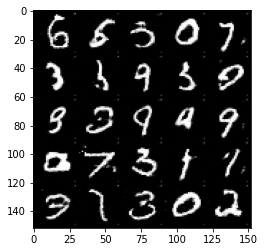

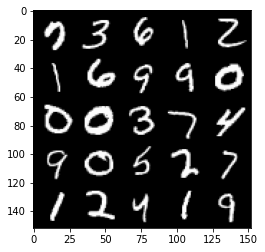

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.6942665034532547, discriminator loss: 0.6934562968015665


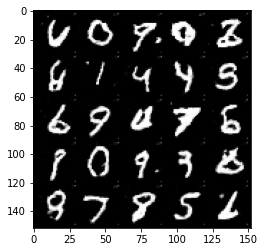

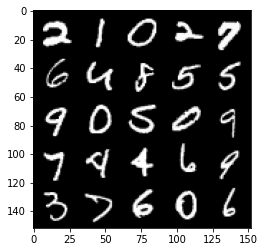

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.6941771879196168, discriminator loss: 0.6933990021944052


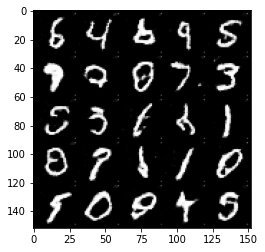

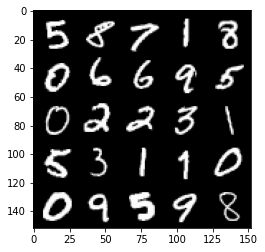

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.6941992208957677, discriminator loss: 0.6934098594188687


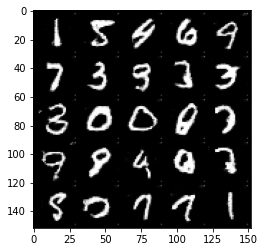

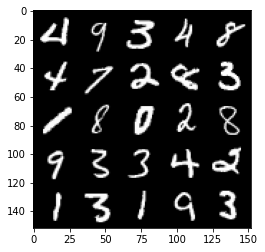

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.6935700287818906, discriminator loss: 0.6934160994291307


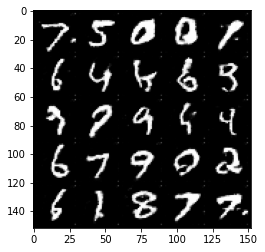

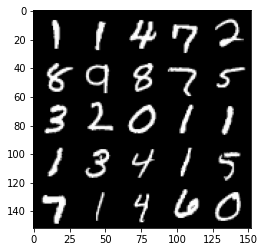

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.6940981519222255, discriminator loss: 0.6935406663417816


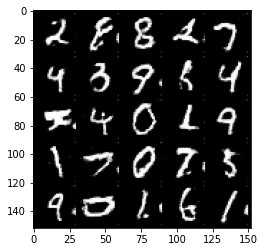

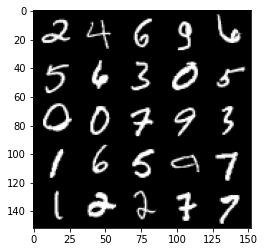

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6938746423721308, discriminator loss: 0.6934669852256778


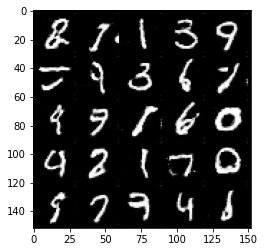

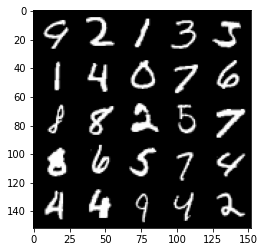

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.6938454451560976, discriminator loss: 0.6934334429502487


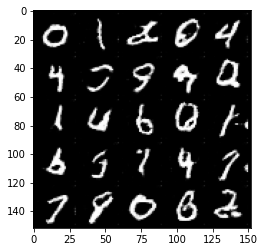

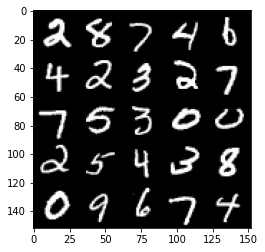

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.693868172764778, discriminator loss: 0.6934208871126171


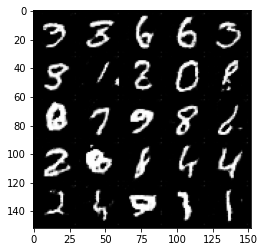

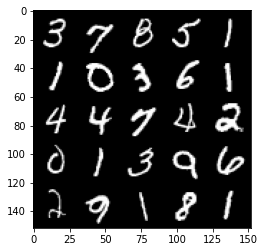

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.6933359384536744, discriminator loss: 0.6934814943075182


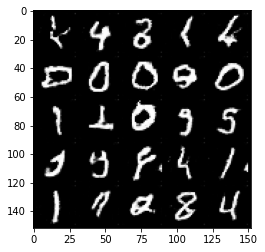

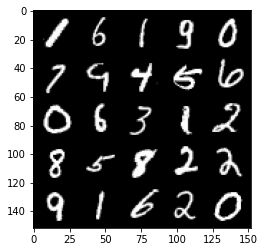

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.693874383330345, discriminator loss: 0.6934745967388143


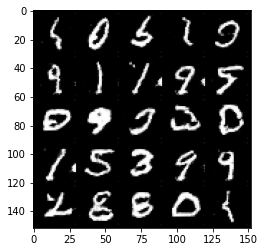

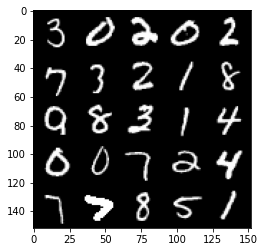

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.6936483651399613, discriminator loss: 0.6934568541049962


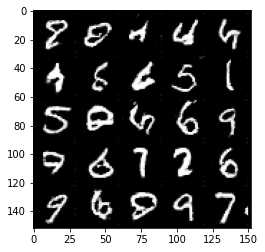

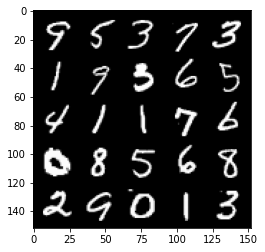

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6936286944150926, discriminator loss: 0.6934711822271349


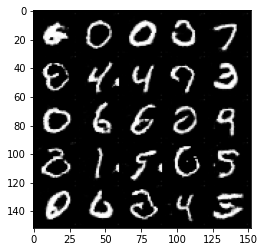

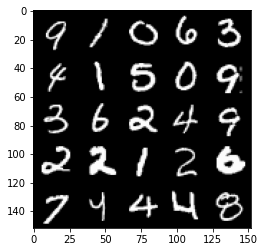

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.6935411926507956, discriminator loss: 0.6933809750080111


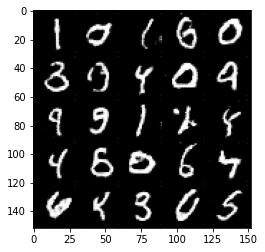

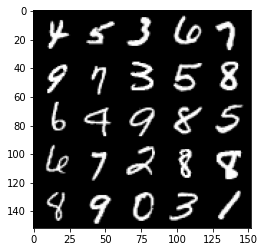

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.6937737953662874, discriminator loss: 0.693457938194274


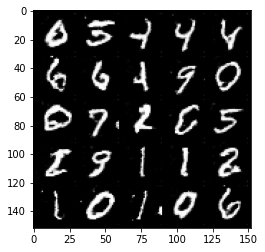

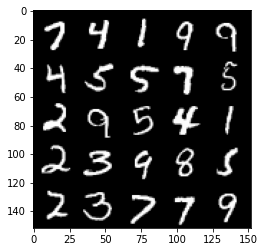

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.6930577414035798, discriminator loss: 0.6934149192571643


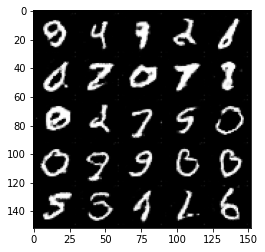

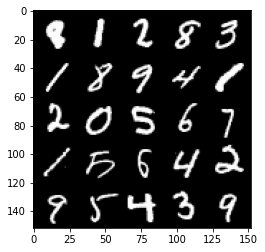

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.6936111809015271, discriminator loss: 0.69341301047802


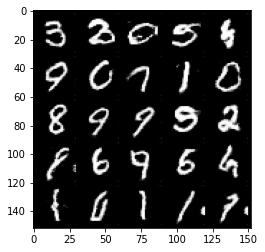

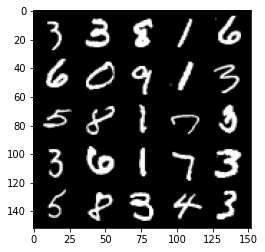

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.6933156899213795, discriminator loss: 0.6933868674039836


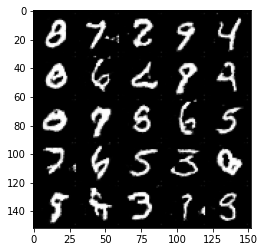

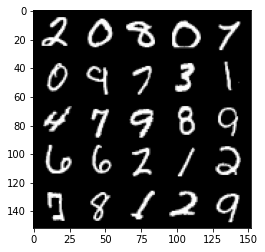

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.6931703776121141, discriminator loss: 0.693378753781319


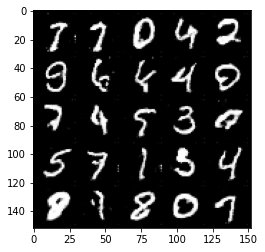

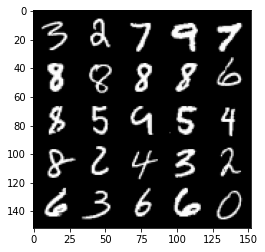

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.6937277215719229, discriminator loss: 0.6933684012889868


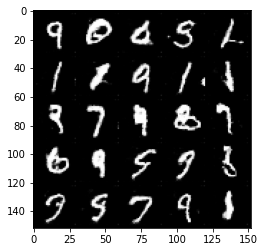

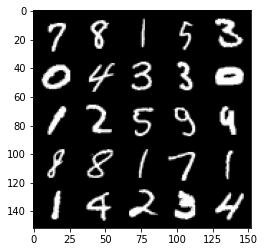

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.6933575125932695, discriminator loss: 0.6933719381093981


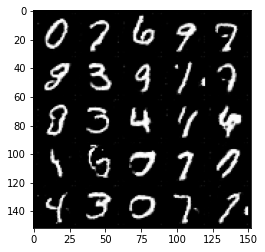

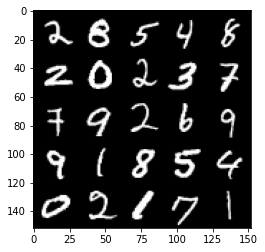

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.6936258978843686, discriminator loss: 0.6933160834312445


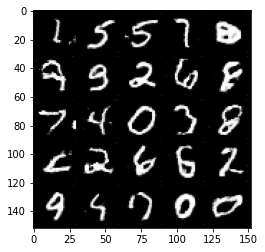

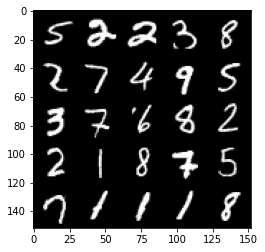

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.6935002627372739, discriminator loss: 0.6933549791574479


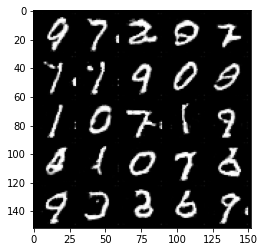

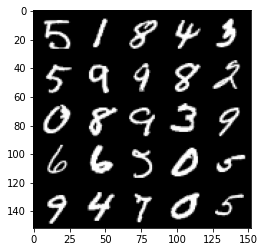

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.6931379150152213, discriminator loss: 0.6933174417018891


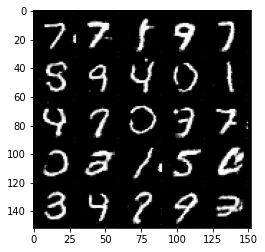

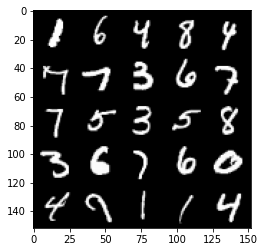

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6932308188676832, discriminator loss: 0.6933183455467221


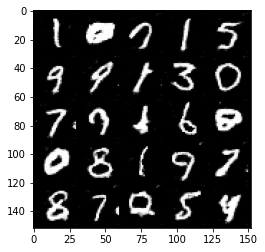

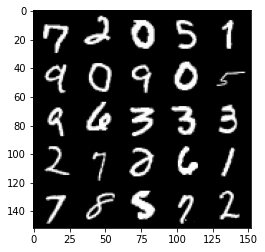

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.6937600824832924, discriminator loss: 0.6933405032157895


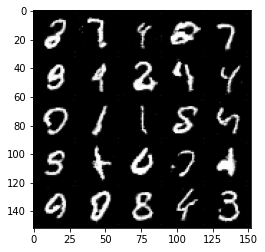

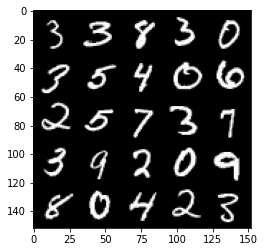

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6930376979112629, discriminator loss: 0.6933164155483251


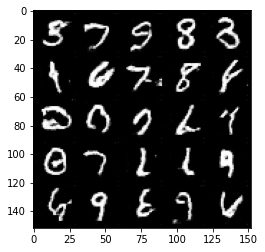

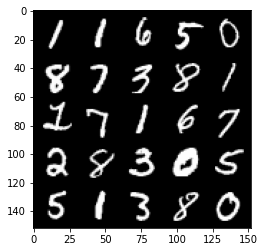

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6930596314668658, discriminator loss: 0.6932912219762793


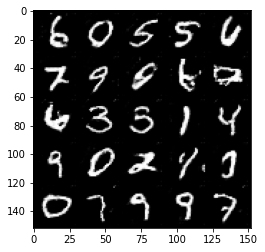

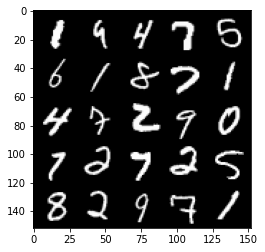

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6934299632310862, discriminator loss: 0.6932748672962192


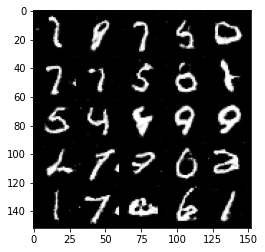

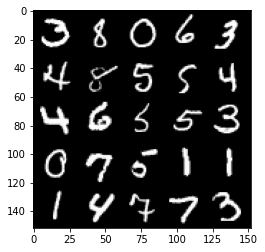

In [7]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1